# Program pipeline

In [1]:
import os
import logging
import numpy as np
import tensorflow as tf
import keras

import dataset_helper
import utils
from utils import show_explanations
from model import InterpretableCautiousText, train, test
from KeywordBank import KeywordBank

os.environ['TZ'] = 'America/Chicago'
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# logger.basicConfig(format='%(asctime)s %(levelname)s %(message)s')

RAND_SEED = 42
np.random.seed(RAND_SEED)
tf.set_random_seed(RAND_SEED)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


## Data load and preprocessing
1. Load keyword from txt file
2. Load the corpus
3. Create object to process keyword along with its connotation (``keywordBank``)
4. Vectorize document and keyword for model input(s)
        Remember: 
        - We have to models (initial assessment, final classifier)
        - Each model has 2 different vectors input (but based on the input document)        

In [2]:
IMDB_PATH = '/home/anneke/Documents/anneke-precision-github/data/aclImdb/'
IMDB_KEYWORD_PATH = '/home/anneke/Documents/anneke-precision-github/Ann-Seq-2-Seq/code/data/imdb-unigrams.txt'

In [3]:
# 1. Load keyword from txt file
with open(IMDB_KEYWORD_PATH, 'r', encoding='utf-8') as keys:
    keyword = []
    for k in keys:
        keyword.append(k.strip())

# 2. Load the corpus
X_train_corpus, y_train, X_test_corpus, y_test = dataset_helper.load_imdb(IMDB_PATH, lower=True, tokenize=True)

# 3. Create object to process keyword along with its connotation (keywordBank)
imdbKeyword = KeywordBank(keyword=keyword, 
                          xtrain=X_train_corpus, 
                          ytrain=y_train)
imdbKeyword.get_connotation()

# 4. Vectorize document and keyword for model input(s)
X_train, X_test = utils.vectorize_keywords_docs(X_train_corpus, X_test_corpus, imdbKeyword)

2019-06-12 20:00:13,156 INFO Train Data loaded.
2019-06-12 20:01:00,279 INFO Test Data loaded.
2019-06-12 20:01:00,407 INFO Shuffled.
2019-06-12 20:01:00,561 INFO Lowered.
2019-06-12 20:03:11,035 INFO Tokenized.


In [4]:
print('-'*40)
print('CORPUS')
print('-'*40)
print('Class: {}'.format(np.unique(y_train)))
print('Train: {} -> ({}, {})'.format(len(y_train), 
                                     np.sum(y_train==0), 
                                     np.sum(y_train==0)))
print('Test: {} -> ({}, {})'.format(len(y_test), 
                                    np.sum(y_test==0), 
                                    np.sum(y_test==0)))
print('-'*40)
print('KEYWORD & VOCABULARY')
print('-'*40)

l = list(imdbKeyword.connotation.values())
con = np.unique(l)

print('Vocabulary: {}'.format(X_train['docs'].shape[1]))
print('Connotation: {}'.format(con))
print('Keyword : {} -> ({}, {})'.format(len(l),
                                        np.sum(l==con[0]),
                                        np.sum(l==con[1])))
del con, l

----------------------------------------
CORPUS
----------------------------------------
Class: [0 1]
Train: 25000 -> (12500, 12500)
Test: 25000 -> (12500, 12500)
----------------------------------------
KEYWORD & VOCABULARY
----------------------------------------
Vocabulary: 3852
Connotation: [-1  1]
Keyword : 83 -> (50, 33)


## Model pipeline
1. Build model
2. Train with desired ``train_mode``
    - **NOTE**: The LR scheduler only activated when trained more than 1 ``epoch``
3. Test with Cautious

Another option to visualize the explanation is by: <br>
* Using Jupyter notebook
* Print to png

<br><br><br>
Below is the **Model illustration** when we have *only* 10 keyword

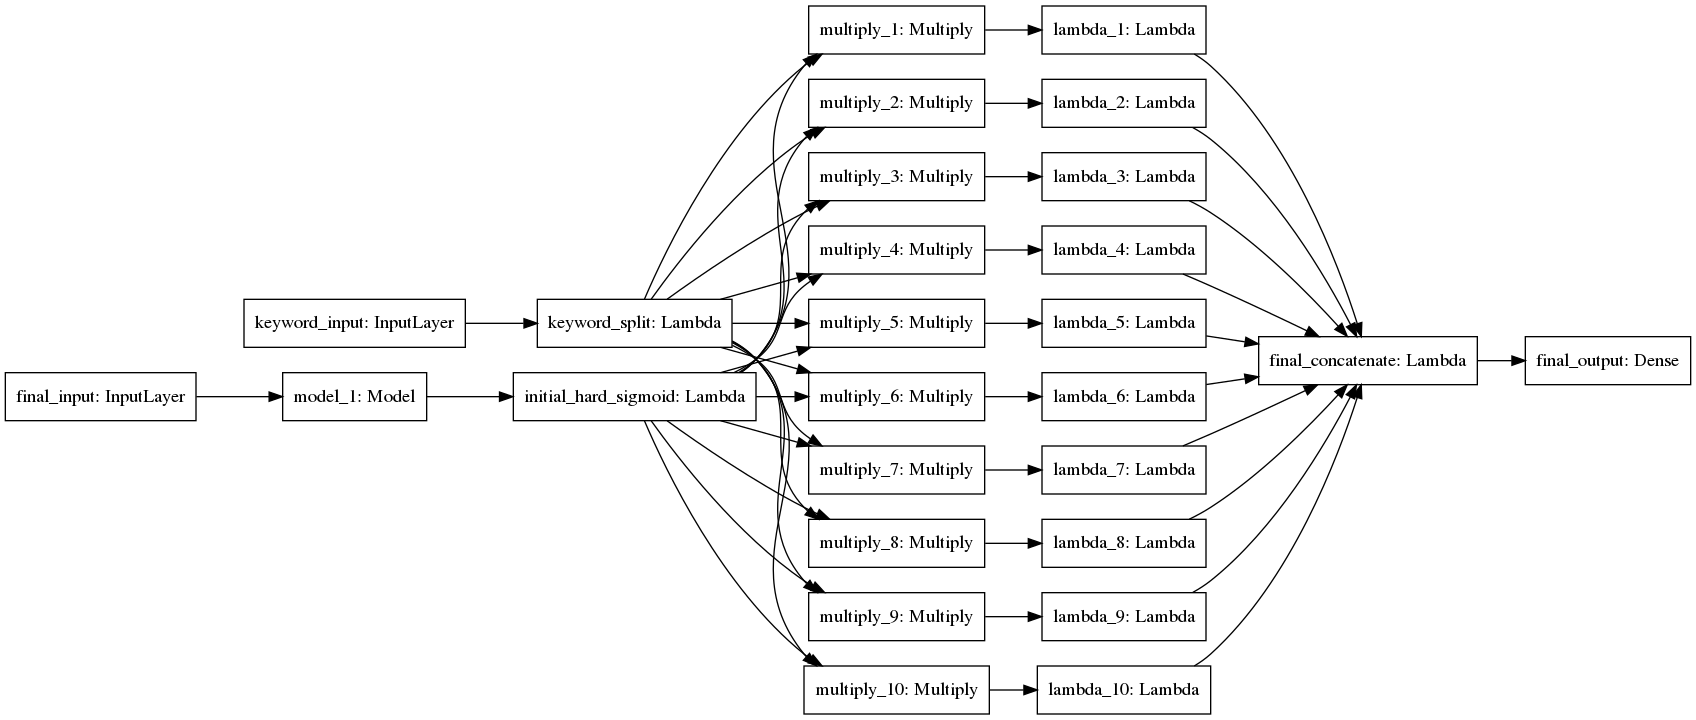

In [5]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image
plt.style.use("seaborn")

illustration = InterpretableCautiousText(100, 10)
plot_model(illustration.final_model, show_shapes=False, show_layer_names=True, to_file='model.png', rankdir='LR')

Image(filename='model.png')

#### Train
**Note** that we have two different inputs. <br>
As shown on tne model illustrations above, we have two input layers:
* ``final_input`` : Document vector
* ``keyword_input`` : Keyword vector which has been processing w.r.t ``doc_vec``

In [6]:
model = InterpretableCautiousText(X_train['docs'].shape[1], len(keyword))

In [7]:
# Note that the final classifier has both params for initial model and final model

print('TOTAL PARAM')
print('-'*40)
print('initial model : {}'.format(model.initial_model.count_params()))
print('final classifier: {}'.format(model.final_model.count_params()))

TOTAL PARAM
----------------------------------------
initial model : 3853
final classifier: 3937


In [8]:
help(train)

Help on function train in module model:

train(model, data, label, train_mode='pre-trained-joint', save_weights=True)
    Train Interpretable and Cautious Model
    
    Helper to train it in a different fashion
    
    # Arguments
        model:
        data:
        label:
        train_mode: {'default-joint', 'pre-trained-frozen', 'pre-trained-joint'}
            Mode on how we train the model. Refer to the paper regarding the training methods



In [9]:
m = train(model, X_train, y_train)

Train on 16666 samples, validate on 8334 samples
Epoch 1/1
16666/16666 [==============================] - 102s 6ms/step - loss: 0.3507 - acc: 0.8585 - val_loss: 0.2837 - val_acc: 0.8907
Train on 16666 samples, validate on 8334 samples
Epoch 1/1
16666/16666 [==============================] - 248s 15ms/step - loss: 0.3803 - acc: 0.8552 - val_loss: 0.3438 - val_acc: 0.8587

Epoch 00001: val_acc improved from -inf to 0.85865, saving model to ./weights/01-0.344-0.859


#### Test
Now, the cautious part of the model starts here. Remember that :
1. The model **predict** the label using explanations
2. The model **output** the label **and** the explanations
3. The model is **cautious** to reject when there is no explanation present in the input document.

In [10]:
help(test)

Help on function test in module model:

test(model, data, label=None, threshold=0.5)
    Test it with rejection rate
    
    # Arguments
        model: InterpretableCautiousText object
        data:
        label:
        threshold:
        
    # Returns
        For each document,
            ['label', 'explanation']
            label: class
            explanation: keyword vector (zero and non-zero)



In [11]:
report, preds, exp_vec = test(m, 
                              X_test, 
                              label=y_test)

21329/21329 [==============================] - 4s 187us/step


In [12]:
report

{'rejection_rate': 0.147,
 'total_reject': 3671,
 'total_accept': 21329,
 'loss': 0.291,
 'acc': 0.906}

### Show the explanations

In [13]:
idx=3
show_explanations(preds[idx], X_test_corpus[idx], exp_vec[idx], imdbKeyword)

Document:


--------------------------------------------------
This document predicted as 0.0 because it has 4 keyword justified as shown below:

- 6/10
- bad
- poor
- unfortunately
